In [1]:
import tripadvisor_hotels_webcrawl as thw

In [2]:
import pandas as pd
import dask.dataframe as dd
from pathlib import Path
from dotenv import load_dotenv
from fuzzywuzzy import fuzz
import io
import geopandas as gpd
from shapely import MultiPolygon, Polygon, Point
import shapely
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
import folium
import geopandas as gpd
import pysal
from sklearn.cluster import DBSCAN
from pointpats import centrography
import contextily as ctx
from shapely.geometry import Point
from matplotlib.patches import Ellipse
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import contextily as ctx


DATA_PATH = "/Users/John/Documents/GitHub/perpetual_dev_john_branches/2024-spring-perpetual/data"
ENV_PATH = "/Users/John/Documents/GitHub/perpetual_dev_john_branches/2024-spring-perpetual/.env"
load_dotenv(dotenv_path=ENV_PATH)

/opt/homebrew/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


True

In [4]:
INFO_PATH = f"{DATA_PATH}/Infogroup/2023_Business_Academic_QCQ.txt"

In [3]:
def create_infogroup_df(file_name, city, state):
    lines_left = True
    with open(file_name, encoding="ISO-8859-1") as f:
        header = f.readline()
        whole_df = None
        while True:
            lines = [header]
            for i in range(5000):
                line = f.readline()
                if not line:
                    lines_left = False
                    break
                lines.append(line)
            df = pd.read_csv(io.StringIO("\n".join(lines)))
            # print(df.columns)
            df_filtered = df.loc[(df.loc[:, "CITY"] == city) & (
                    df.loc[:, "STATE"] == state), :]
            if len(df_filtered) > 0:
                whole_df = df_filtered if whole_df is None else pd.concat([whole_df, df_filtered])
            if not lines_left:
                return whole_df

In [5]:
def change_infogroup_column_names(df):
    df.loc[:, ["infogroup"]] = True
    df = df.loc[:, ["COMPANY", "CITY", "ADDRESS LINE 1", "LATITUDE", "LONGITUDE", "SALES VOLUME (9) - LOCATION", "EMPLOYEE SIZE (5) - LOCATION", "PARENT ACTUAL SALES VOLUME"]]
    df = df.rename(columns={"ADDRESS LINE 1": "street1", "CITY": "city", "COMPANY": "name", "LATITUDE": "latitude", "LONGITUDE": "longitude", "SALES VOLUME (9) - LOCATION": "sales_volume", "EMPLOYEE SIZE (5) - LOCATION": "employee_size", "PARENT ACTUAL SALES VOLUME": "parent_sales_volume"})
    return df


def change_foottraffic_column_names(df):
    df.loc[:, ["foottraffic"]] = True
    df = df.rename(columns={"location_name": "name", "street_address": "street1"})
    return df


def concat_dfs(df_hotel, df_foottraffic, df_infogroup):
    return pd.concat([df_hotel, df_foottraffic, df_infogroup], ignore_index=True)


# Ann Arbor

In [134]:
ann_arbor_info_df = create_infogroup_df(INFO_PATH, "ANN ARBOR", "MI")

In [137]:
ann_arbor_patterns_df = pd.read_parquet(f"{DATA_PATH}/foot-traffic/ann_arbor.parquet")

In [138]:
ann_arbor_patterns_df.loc[:, "city"] = ann_arbor_patterns_df.loc[:, "city"].str.lower().str.strip()
ann_arbor_patterns_df.loc[:, "year"] = ann_arbor_patterns_df.loc[:, "date_range_start"].str[0:4].astype("Int64")
ann_arbor_foot_df = ann_arbor_patterns_df.loc[(ann_arbor_patterns_df.loc[:, "year"] >= 2018), :]
ann_arbor_foot_df.loc[:, "location_name"] = ann_arbor_foot_df.loc[:, "location_name"].str.upper().str.strip()
ann_arbor_foot_df.loc[:, "street_address"] = ann_arbor_foot_df.loc[:, "street_address"].str.upper().str.strip()
ann_arbor_foot_traffic_df = ann_arbor_foot_df.groupby(["location_name", "latitude", "longitude", "street_address"]).agg({"raw_visit_counts": "sum", "raw_visitor_counts": "sum"}).reset_index()
ann_arbor_foot_traffic_df.columns

Index(['location_name', 'latitude', 'longitude', 'street_address',
       'raw_visit_counts', 'raw_visitor_counts'],
      dtype='object')

In [139]:
ann_arbor_foot_traffic_df.head(5)

location_name   latitude  longitude      street_address  \
0                  1 800 CARS4CASH  42.209615 -83.733019     5455 S STATE RD   
1                         16 HANDS  42.284325 -83.746091  407 N 5TH AVE FL 2   
2                         19 DRIPS  42.273684 -83.777626   2263 W LIBERTY ST   
3             242 COMMUNITY CHURCH  42.276102 -83.801800     648 S WAGNER RD   
4  3FIFTEEN ANN ARBOR RECREATIONAL  42.254874 -83.687473  3720 WASHTENAW AVE   

   raw_visit_counts  raw_visitor_counts  
0            1623.0               768.0  
1              24.0                23.0  
2             405.0               287.0  
3           18474.0              8600.0  
4            1677.0              1341.0

In [141]:
ann_arbor_api_hotel_df = pd.read_csv("/Users/John/Documents/GitHub/perpetual_dev_john_branches/2024-spring-perpetual/data/tripadvisor_data/Ann_Arbor_hotels_api.csv")
ann_arbor_crawled_hotel_df = pd.read_csv("/Users/John/Documents/GitHub/perpetual_dev_john_branches/2024-spring-perpetual/data/tripadvisor_data/Ann_Arbor_hotels_crawled.csv")

In [143]:
ann_arbor_api_hotel_df.loc[:, "name"] = ann_arbor_api_hotel_df.loc[:, "name"].str.upper().str.strip()
ann_arbor_api_hotel_df.loc[:, "street1"] = ann_arbor_api_hotel_df.loc[:, "street1"].str.upper().str.strip()
ann_arbor_api_hotel_df.loc[:, "city"] = ann_arbor_api_hotel_df.loc[:, "city"].str.upper().str.strip()

ann_arbor_crawled_hotel_df.loc[:, "name"] = ann_arbor_crawled_hotel_df.loc[:, "name"].str.upper().str.strip()
ann_arbor_crawled_hotel_df.loc[:, "street1"] = ann_arbor_crawled_hotel_df.loc[:, "street1"].str.upper().str.strip()
ann_arbor_crawled_hotel_df.loc[:, "city"] = ann_arbor_crawled_hotel_df.loc[:, "city"].str.upper().str.strip()

In [145]:
ann_arbor_business_df = change_infogroup_column_names(ann_arbor_info_df)
ann_arbor_foot_traffic_df = change_foottraffic_column_names(ann_arbor_foot_traffic_df)

ann_arbor_api_concat_df = pd.concat([ann_arbor_api_hotel_df, ann_arbor_foot_traffic_df, ann_arbor_business_df], ignore_index=True)
ann_arbor_crawled_concat_df = pd.concat([ann_arbor_crawled_hotel_df, ann_arbor_foot_traffic_df, ann_arbor_business_df], ignore_index=True)

In [146]:
Ann_Arbor_geo = thw.CityGeo("Ann Arbor")

### Ann Arbor API

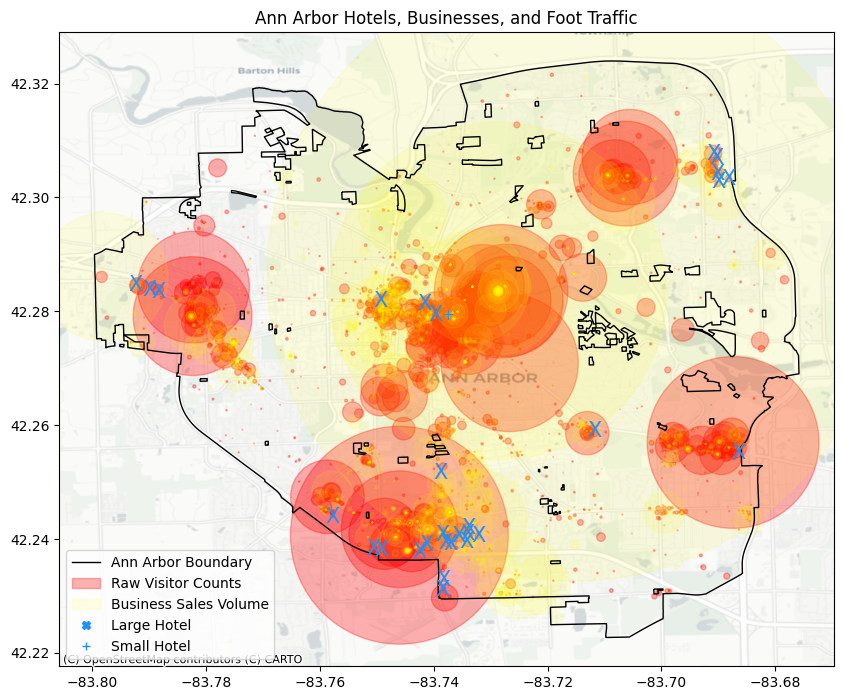

In [189]:
ann_arbor_boundary = gpd.GeoDataFrame(geometry=[Ann_Arbor_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    ann_arbor_api_concat_df,
    geometry=gpd.points_from_xy(ann_arbor_api_concat_df.longitude, ann_arbor_api_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(ann_arbor_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = ann_arbor_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Ann Arbor Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Ann Arbor Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_title("Ann Arbor Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker])


plt.show()


### Ann Arbor WebCrawl

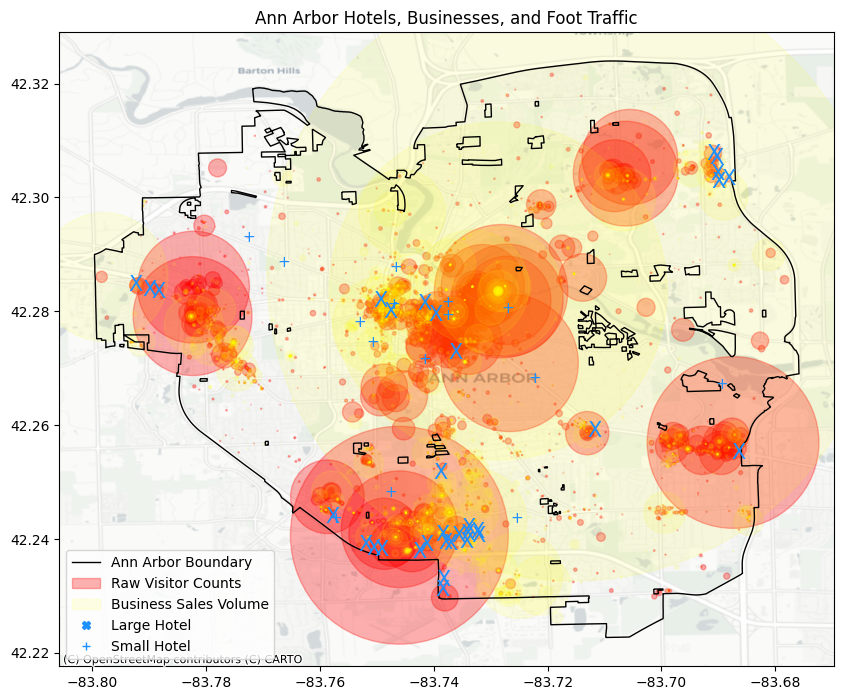

In [190]:
ann_arbor_boundary = gpd.GeoDataFrame(geometry=[Ann_Arbor_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    ann_arbor_crawled_concat_df,
    geometry=gpd.points_from_xy(ann_arbor_crawled_concat_df.longitude, ann_arbor_crawled_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(ann_arbor_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = ann_arbor_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Ann Arbor Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Ann Arbor Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_title("Ann Arbor Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker])


plt.show()


# Galveston

In [142]:
galveston_info_df = create_infogroup_df(INFO_PATH, "GALVESTON", "TX")

In [151]:
galveston_patterns_df = pd.read_parquet(f"{DATA_PATH}/foot-traffic/galveston_full_patterns.parquet")

In [152]:
galveston_patterns_df.loc[:, "city"] = galveston_patterns_df.loc[:, "city"].str.lower().str.strip()
galveston_patterns_df.loc[:, "year"] = galveston_patterns_df.loc[:, "date_range_start"].str[0:4].astype("Int64")
galveston_foot_df = galveston_patterns_df.loc[(galveston_patterns_df.loc[:, "year"] >= 2018), :]
galveston_foot_df.loc[:, "location_name"] = galveston_foot_df.loc[:, "location_name"].str.upper().str.strip()
galveston_foot_df.loc[:, "street_address"] = galveston_foot_df.loc[:, "street_address"].str.upper().str.strip()
galveston_foot_traffic_df = galveston_foot_df.groupby(["location_name", "latitude", "longitude", "street_address"]).agg({"raw_visit_counts": "sum", "raw_visitor_counts": "sum"}).reset_index()
galveston_foot_traffic_df.columns

Index(['location_name', 'latitude', 'longitude', 'street_address',
       'raw_visit_counts', 'raw_visitor_counts'],
      dtype='object')

In [153]:
galveston_foot_traffic_df.head(5)

location_name   latitude  longitude       street_address  \
0          101 MOBILITY  29.286937 -94.795282    2902 AVENUE R 1/2   
1  1892 BISHOP'S PALACE  29.303046 -94.782172     1402 BROADWAY ST   
2                    21  29.305311 -94.791623  2102 POST OFFICE ST   
3   23RD STREET STATION  29.293649 -94.789381         1706 23RD ST   
4      3 DOORS DOWN BAR  29.308643 -94.790892          102 20TH ST   

   raw_visit_counts  raw_visitor_counts  
0            2994.0              1381.0  
1           14573.0             10858.0  
2           11147.0              9042.0  
3           11452.0              5422.0  
4             244.0               181.0

In [159]:
galveston_api_hotel_df = pd.read_csv(f"{DATA_PATH}/tripadvisor_data/Galveston_hotels_api.csv")
galveston_crawled_hotel_df = pd.read_csv(f"{DATA_PATH}/tripadvisor_data/Galveston_hotels_crawled.csv")

In [160]:
galveston_api_hotel_df.loc[:, "name"] = galveston_api_hotel_df.loc[:, "name"].str.upper().str.strip()
galveston_api_hotel_df.loc[:, "street1"] = galveston_api_hotel_df.loc[:, "street1"].str.upper().str.strip()
galveston_api_hotel_df.loc[:, "city"] = galveston_api_hotel_df.loc[:, "city"].str.upper().str.strip()

galveston_crawled_hotel_df.loc[:, "name"] = galveston_crawled_hotel_df.loc[:, "name"].str.upper().str.strip()
galveston_crawled_hotel_df.loc[:, "street1"] = galveston_crawled_hotel_df.loc[:, "street1"].str.upper().str.strip()
galveston_crawled_hotel_df.loc[:, "city"] = galveston_crawled_hotel_df.loc[:, "city"].str.upper().str.strip()

In [161]:
galveston_business_df = change_infogroup_column_names(galveston_info_df)
galveston_foot_traffic_df = change_foottraffic_column_names(galveston_foot_traffic_df)

galveston_api_concat_df = pd.concat([galveston_api_hotel_df, galveston_foot_traffic_df, galveston_business_df], ignore_index=True)
galveston_crawled_concat_df = pd.concat([galveston_crawled_hotel_df, galveston_foot_traffic_df, galveston_business_df], ignore_index=True)

In [162]:
Galveston_geo = thw.CityGeo("Galveston")

### Galveston API

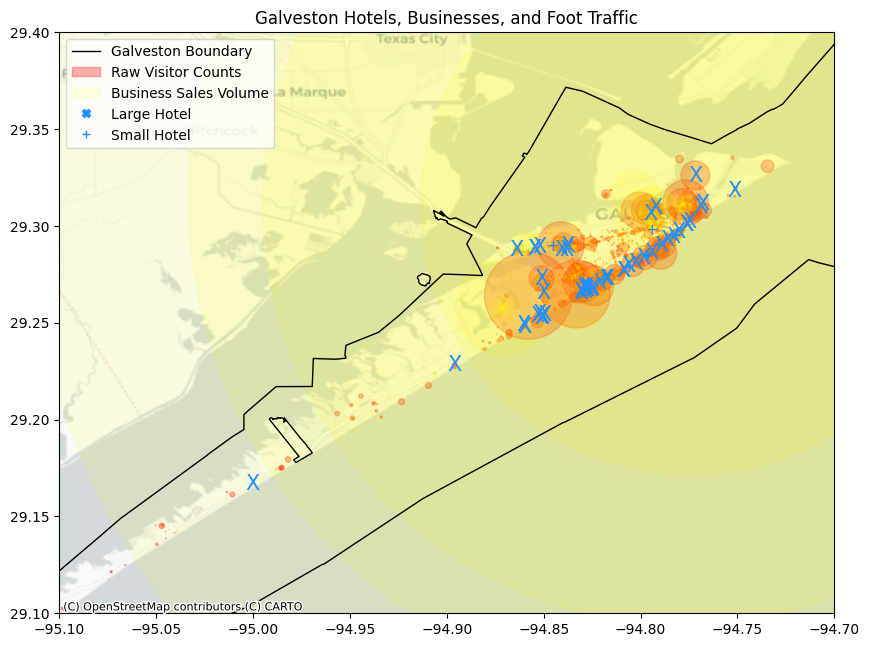

In [186]:
galveston_boundary = gpd.GeoDataFrame(geometry=[Galveston_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    galveston_api_concat_df,
    geometry=gpd.points_from_xy(galveston_api_concat_df.longitude, galveston_api_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(galveston_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = galveston_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Galveston Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Galveston Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_xlim([-95.1, -94.7])
ax.set_ylim([29.10, 29.40])

ax.set_title("Galveston Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker], loc="upper left")


plt.show()


### Galveston WebCrawl

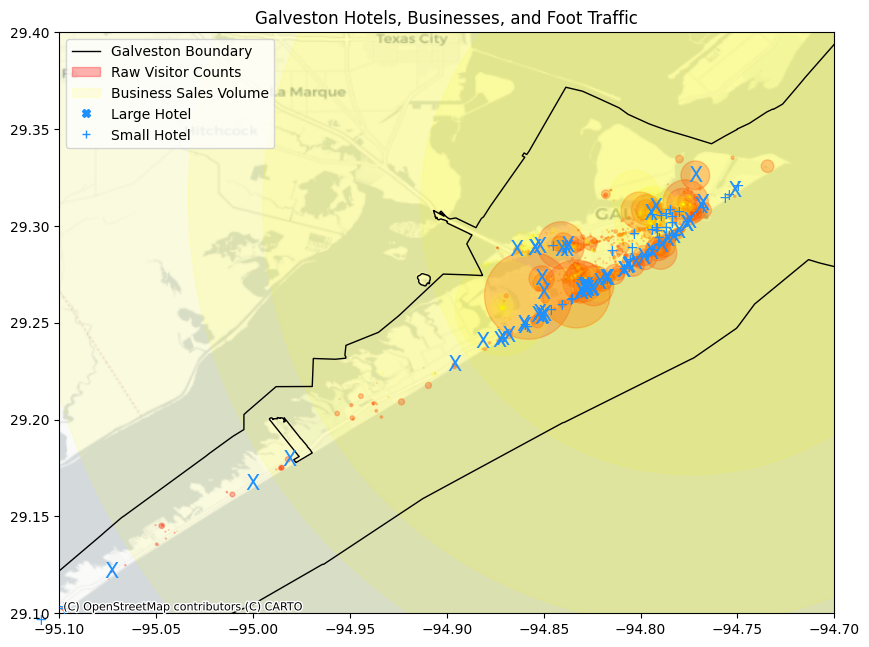

In [185]:
galveston_boundary = gpd.GeoDataFrame(geometry=[Galveston_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    galveston_crawled_concat_df,
    geometry=gpd.points_from_xy(galveston_crawled_concat_df.longitude, galveston_crawled_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(galveston_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = galveston_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Galveston Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Galveston Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_xlim([-95.1, -94.7])
ax.set_ylim([29.10, 29.40])

ax.set_title("Galveston Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker], loc="upper left")


plt.show()


# Hilo

In [6]:
hilo_info_df = create_infogroup_df(INFO_PATH, "HILO", "HI")

- sales volume at location
- parent sales volume
- number of employees

In [7]:
hilo_info_df.columns

Index(['COMPANY', 'ADDRESS LINE 1', 'CITY', 'STATE', 'ZIPCODE', 'ZIP4',
       'COUNTY CODE', 'AREA CODE', 'IDCODE', 'LOCATION EMPLOYEE SIZE CODE',
       'LOCATION SALES VOLUME CODE', 'PRIMARY SIC CODE', 'SIC6_DESCRIPTIONS',
       'PRIMARY NAICS CODE', 'NAICS8 DESCRIPTIONS', 'SIC CODE',
       'SIC6_DESCRIPTIONS (SIC)', 'SIC CODE 1', 'SIC6_DESCRIPTIONS (SIC1)',
       'SIC CODE 2', 'SIC6_DESCRIPTIONS(SIC2)', 'SIC CODE 3',
       'SIC6_DESCRIPTIONS(SIC3)', 'SIC CODE 4', 'SIC6_DESCRIPTIONS(SIC4)',
       'ARCHIVE VERSION YEAR', 'YELLOW PAGE CODE',
       'EMPLOYEE SIZE (5) - LOCATION', 'SALES VOLUME (9) - LOCATION',
       'BUSINESS STATUS CODE', 'INDUSTRY SPECIFIC FIRST BYTE',
       'YEAR ESTABLISHED', 'OFFICE SIZE CODE', 'COMPANY HOLDING STATUS', 'ABI',
       'SUBSIDIARY NUMBER', 'PARENT NUMBER', 'PARENT ACTUAL EMPLOYEE SIZE',
       'PARENT ACTUAL SALES VOLUME', 'PARENT EMPLOYEE SIZE CODE',
       'PARENT SALES VOLUME CODE', 'SITE NUMBER', 'ADDRESS TYPE INDICATOR',
       'POPULAT

In [8]:
hilo_business_df = hilo_info_df.loc[:, ["COMPANY", "ADDRESS LINE 1", "CITY", "LATITUDE", "LONGITUDE", "SALES VOLUME (9) - LOCATION", "EMPLOYEE SIZE (5) - LOCATION", "PARENT ACTUAL SALES VOLUME"]]


In [168]:
hilo_full_patterns_df = pd.read_parquet(f"{DATA_PATH}/foot-traffic/hilo_full_patterns.parquet")

In [170]:
hilo_full_patterns_df.columns

Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs'],
      dtype='object')

In [11]:
hilo_full_patterns_df.loc[:, "raw_visit_counts"]

2353         NaN
3153        72.0
3422         NaN
4179        59.0
9436       206.0
           ...  
506689       NaN
507478       3.0
514153       NaN
534386    1777.0
540183      48.0
Name: raw_visit_counts, Length: 47954, dtype: float64

In [12]:
hilo_full_patterns_df.loc[:, "raw_visitor_counts"]

2353        NaN
3153       45.0
3422        NaN
4179        9.0
9436       58.0
          ...  
506689      NaN
507478      3.0
514153      NaN
534386    827.0
540183     26.0
Name: raw_visitor_counts, Length: 47954, dtype: float64

In [ ]:
hilo_full_patterns_df.head(5)

placekey                   safegraph_place_id  \
2353  zzw-223@bp4-jct-t5f  sg:a6abadf575c64c7aa2957973c322c258   
3153  22d-222@bp4-jct-f75  sg:e170329441704027b328f7603705729f   
3422  226-222@bp4-jct-zpv  sg:f6130790a4c7440592d15fe1a58888a6   
4179  zzy-222@bp4-jcw-xkf  sg:2dc8ca526096494b8694c5ba704704f1   
9436  zzw-223@bp4-jcv-2ff  sg:9ce49fae5cba4828990d087fb1eaaf75   

          parent_placekey            parent_safegraph_place_id  \
2353                 None                                 None   
3153  228-222@bp4-jct-hkf  sg:d4f8d56cb61345e6b33a5a1382a503d7   
3422                 None                                 None   
4179  zzw-222@bp4-jfh-47q  sg:5bcbf8781047448ab852bfc69c5c515e   
9436                 None                                 None   

                           location_name  \
2353                                YMCA   
3153     Happy Valley Seafood Restaurant   
3422                  Two Ladies Kitchen   
4179  Wailoa River State Recreation Area   
9436             Hawaii Probation Office   

                            safegraph_brand_ids brands  \
2353  SG_BRAND_8c40d09d7a855232f6ae8762ffd5966a   YMCA   
3153                                       None   None   
3422                                       None   None   
4179                                       None   None   
9436                                       None   None   

                                           top_category  \
2353                     Individual and Family Services   
3153                Restaurants and Other Eating Places   
3422                Bakeries and Tortilla Manufacturing   
4179  Museums, Historical Sites, and Similar Institu...   
9436       Justice, Public Order, and Safety Activities   

                                     sub_category   category_tags  ...  \
2353         Other Individual and Family Services            None  ...   
3153                     Full-Service Restaurants    Chinese Food  ...   
3422                              Retail Bakeries  Dessert,Bakery  ...   
4179  Nature Parks and Other Similar Institutions            None  ...   
9436                                       Courts            None  ...   

      median_dwell                               bucketed_dwell_times  \
2353           NaN                                               None   
3153          14.0  {"<5":10,"5-10":23,"11-20":11,"21-60":18,"61-1...   
3422           NaN                                               None   
4179          47.0  {"<5":0,"5-10":5,"11-20":15,"21-60":13,"61-120...   
9436          63.5  {"<5":4,"5-10":41,"11-20":20,"21-60":34,"61-12...   

                                 related_same_day_brand  \
2353                                               None   
3153                                                 {}   
3422                                               None   
4179                   {"Panda Express":50,"Target":48}   
9436  {"7-Eleven":19,"76":17,"Starbucks":11,"Walmart...   

                               related_same_month_brand  \
2353                                               None   
3153  {"CVS":57,"Target":49,"7-Eleven":35,"Walmart":...   
3422                                               None   
4179  {"CVS":51,"Target":49,"Walmart":44,"Minit Stop...   
9436  {"CVS":52,"Walmart":36,"Burger King":35,"The H...   

                                     popularity_by_hour  \
2353                                               None   
3153  [1,1,0,1,0,0,2,8,6,7,10,13,15,13,9,11,7,3,0,1,...   
3422                                               None   
4179  [0,1,0,0,0,0,0,13,17,12,18,14,6,4,12,12,8,1,1,...   
9436  [0,0,0,0,0,0,21,64,60,67,62,67,59,45,37,33,30,...   

                                      popularity_by_day  \
2353                                               None   
3153  {"Monday":13,"Tuesday":9,"Wednesday":11,"Thurs...   
3422                                               None   
4179  {"Monday":6,"Tuesday":6,"Wednesday":14,"Thursd...   
9436  {"Mo

In [14]:
hilo_full_patterns_df.loc[:, "city"] = hilo_full_patterns_df.loc[:, "city"].str.lower().str.strip()
hilo_full_patterns_df.loc[:, "year"] = hilo_full_patterns_df.loc[:, "date_range_start"].str[0:4].astype("Int64")
hilo_foot_df = hilo_full_patterns_df.loc[(hilo_full_patterns_df.loc[:, "year"] >= 2018), :]
hilo_foot_df.loc[:, "location_name"] = hilo_foot_df.loc[:, "location_name"].str.upper().str.strip()
hilo_foot_df.loc[:, "street_address"] = hilo_foot_df.loc[:, "street_address"].str.upper().str.strip()
hilo_foot_traffic_df = hilo_foot_df.groupby(["location_name", "latitude", "longitude", "street_address"]).agg({"raw_visit_counts": "sum", "raw_visitor_counts": "sum"}).reset_index()
hilo_foot_traffic_df.columns

Index(['location_name', 'latitude', 'longitude', 'street_address',
       'raw_visit_counts', 'raw_visitor_counts'],
      dtype='object')

In [15]:
hilo_foot_traffic_df.head(5)

location_name   latitude   longitude            street_address  \
0       'OHANA ENDODONTICS  19.707470 -155.074925   31 E LANIKAULA ST STE C   
1            1 PLUS 1 CAFE  19.701519 -155.063193  315 E MAKAALA ST STE 110   
2  2 THE POINT ACUPUNCTURE  19.709667 -155.066911            687 LAUKAPU ST   
3                 7-ELEVEN  19.702743 -155.074853            74 W KAWILI ST   
4                 7-ELEVEN  19.709726 -155.075784          1321 KILAUEA AVE   

   raw_visit_counts  raw_visitor_counts  
0               5.0                 4.0  
1            1734.0              1319.0  
2            1524.0               737.0  
3           13652.0              8285.0  
4           10300.0              5952.0

In [16]:
hilo_api_hotel_df = pd.read_csv("/Users/John/Documents/GitHub/perpetual_dev_john_branches/2024-spring-perpetual/data/tripadvisor_data/Hilo_hotels_api.csv")
hilo_crawled_hotel_df = pd.read_csv("/Users/John/Documents/GitHub/perpetual_dev_john_branches/2024-spring-perpetual/data/tripadvisor_data/Hilo_hotels_crawled.csv")

In [17]:
hilo_api_hotel_df.columns

Index(['location_id', 'name', 'distance', 'address_string', 'city', 'street1',
       'web_url', 'latitude', 'longitude', 'rating', 'num_reviews',
       'price_level', 'number_of_rooms'],
      dtype='object')

In [18]:
hilo_crawled_hotel_df.columns

Index(['location_id', 'name', 'web_url', 'latitude', 'longitude', 'rating',
       'num_reviews', 'price_level', 'address_string', 'city', 'street1',
       'number_of_rooms'],
      dtype='object')

In [19]:
hilo_api_hotel_df.loc[:, "name"] = hilo_api_hotel_df.loc[:, "name"].str.upper().str.strip()
hilo_api_hotel_df.loc[:, "street1"] = hilo_api_hotel_df.loc[:, "street1"].str.upper().str.strip()
hilo_api_hotel_df.loc[:, "city"] = hilo_api_hotel_df.loc[:, "city"].str.upper().str.strip()

hilo_crawled_hotel_df.loc[:, "name"] = hilo_crawled_hotel_df.loc[:, "name"].str.upper().str.strip()
hilo_crawled_hotel_df.loc[:, "street1"] = hilo_crawled_hotel_df.loc[:, "street1"].str.upper().str.strip()
hilo_crawled_hotel_df.loc[:, "city"] = hilo_crawled_hotel_df.loc[:, "city"].str.upper().str.strip()

In [54]:
hilo_business_df = change_infogroup_column_names(hilo_business_df)
hilo_foot_traffic_df = change_foottraffic_column_names(hilo_foot_traffic_df)

hilo_api_concat_df = pd.concat([hilo_api_hotel_df, hilo_foot_traffic_df, hilo_business_df], ignore_index=True)

In [131]:
hilo_crawled_concat_df = pd.concat([hilo_crawled_hotel_df, hilo_foot_traffic_df, hilo_business_df], ignore_index=True)

In [55]:
hilo_api_concat_df.columns

Index(['location_id', 'name', 'distance', 'address_string', 'city', 'street1',
       'web_url', 'latitude', 'longitude', 'rating', 'num_reviews',
       'price_level', 'number_of_rooms', 'raw_visit_counts',
       'raw_visitor_counts', 'foottraffic', 'sales_volume', 'employee_size',
       'parent_sales_volume', 'infogroup'],
      dtype='object')

In [56]:
Hilo_geo = thw.CityGeo("Hilo")


### Hilo API

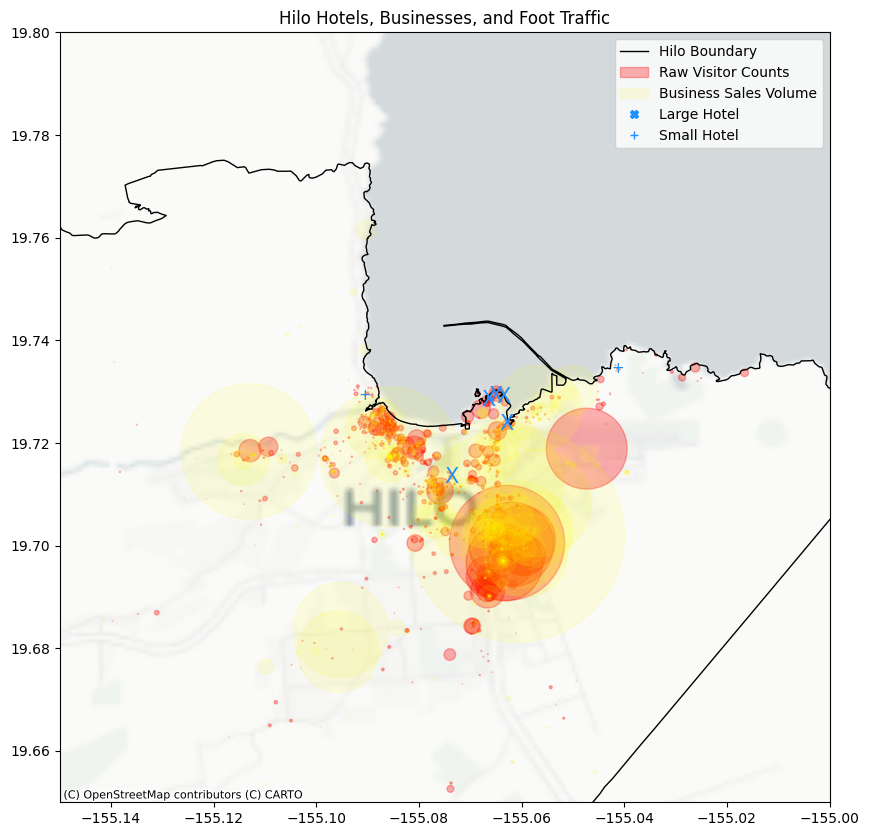

In [130]:
hilo_boundary = gpd.GeoDataFrame(geometry=[Hilo_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    hilo_api_concat_df,
    geometry=gpd.points_from_xy(hilo_api_concat_df.longitude, hilo_api_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(hilo_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = hilo_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Hilo Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Hilo Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_xlim([-155.15, -155.00])
ax.set_ylim([19.65, 19.80])

ax.set_title("Hilo Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker])


plt.show()


### Hilo WebCrawl

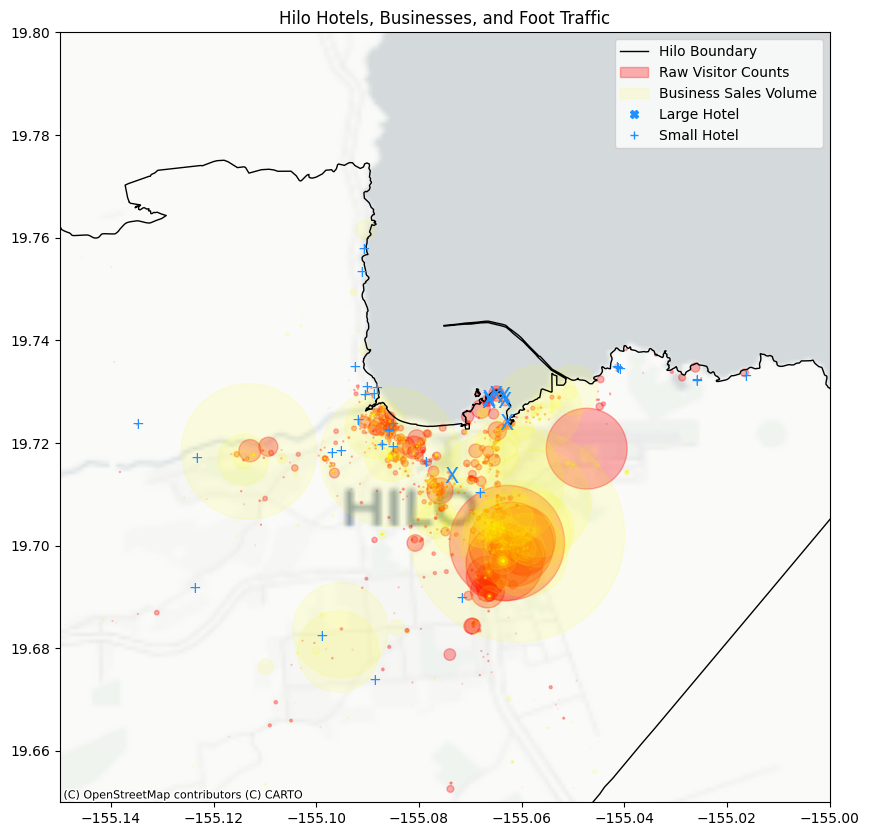

In [133]:
hilo_boundary = gpd.GeoDataFrame(geometry=[Hilo_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    hilo_crawled_concat_df,
    geometry=gpd.points_from_xy(hilo_crawled_concat_df.longitude, hilo_crawled_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(hilo_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = hilo_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Hilo Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Hilo Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_xlim([-155.15, -155.00])
ax.set_ylim([19.65, 19.80])

ax.set_title("Hilo Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker])

plt.show()


# Jersey City

In [172]:
jersey_city_info_df = create_infogroup_df(INFO_PATH, "JERSEY CITY", "NJ")

In [173]:
jersey_city_patterns_df = pd.read_parquet(f"{DATA_PATH}/foot-traffic/jersey_city_full_patterns.parquet")

In [174]:
jersey_city_patterns_df.loc[:, "city"] = jersey_city_patterns_df.loc[:, "city"].str.lower().str.strip()
jersey_city_patterns_df.loc[:, "year"] = jersey_city_patterns_df.loc[:, "date_range_start"].str[0:4].astype("Int64")
jersey_city_foot_df = jersey_city_patterns_df.loc[(jersey_city_patterns_df.loc[:, "year"] >= 2018), :]
jersey_city_foot_df.loc[:, "location_name"] = jersey_city_foot_df.loc[:, "location_name"].str.upper().str.strip()
jersey_city_foot_df.loc[:, "street_address"] = jersey_city_foot_df.loc[:, "street_address"].str.upper().str.strip()
jersey_city_foot_traffic_df = jersey_city_foot_df.groupby(["location_name", "latitude", "longitude", "street_address"]).agg({"raw_visit_counts": "sum", "raw_visitor_counts": "sum"}).reset_index()
jersey_city_foot_traffic_df.columns


Index(['location_name', 'latitude', 'longitude', 'street_address',
       'raw_visit_counts', 'raw_visitor_counts'],
      dtype='object')

In [175]:
jersey_city_foot_traffic_df.head(5)

location_name   latitude  longitude            street_address  \
0                     &PIZZA  40.716755 -74.035406  30 MONTGOMERY ST STE 202   
1              1-800-FLOWERS  40.719045 -74.082688            532 W SIDE AVE   
2             10 SPOT/MADRAG  40.731954 -74.065609  2849 JOHN F KENNEDY BLVD   
3  14TH STREET GARDEN CENTER  40.732466 -74.044603            793 JERSEY AVE   
4               15 FOX PLACE  40.733737 -74.072529                 15 FOX PL   

   raw_visit_counts  raw_visitor_counts  
0           25893.0             13544.0  
1            4033.0              2902.0  
2            4813.0              3507.0  
3            5962.0              4558.0  
4           12889.0              5563.0

In [176]:
jersey_city_api_hotel_df = pd.read_csv(f"{DATA_PATH}/tripadvisor_data/Jersey_City_hotels_api.csv")
jersey_city_crawled_hotel_df = pd.read_csv(f"{DATA_PATH}/tripadvisor_data/Jersey_City_hotels_crawled.csv")

In [177]:
jersey_city_api_hotel_df.loc[:, "name"] = jersey_city_api_hotel_df.loc[:, "name"].str.upper().str.strip()
jersey_city_api_hotel_df.loc[:, "street1"] = jersey_city_api_hotel_df.loc[:, "street1"].str.upper().str.strip()
jersey_city_api_hotel_df.loc[:, "city"] = jersey_city_api_hotel_df.loc[:, "city"].str.upper().str.strip()

jersey_city_crawled_hotel_df.loc[:, "name"] = jersey_city_crawled_hotel_df.loc[:, "name"].str.upper().str.strip()
jersey_city_crawled_hotel_df.loc[:, "street1"] = jersey_city_crawled_hotel_df.loc[:, "street1"].str.upper().str.strip()
jersey_city_crawled_hotel_df.loc[:, "city"] = jersey_city_crawled_hotel_df.loc[:, "city"].str.upper().str.strip()

In [179]:
jersey_city_business_df = change_infogroup_column_names(jersey_city_info_df)
jersey_city_foot_traffic_df = change_foottraffic_column_names(jersey_city_foot_traffic_df)

jersey_city_api_concat_df = pd.concat([jersey_city_api_hotel_df, jersey_city_foot_traffic_df, jersey_city_business_df], ignore_index=True)
jersey_city_crawled_concat_df = pd.concat([jersey_city_crawled_hotel_df, jersey_city_foot_traffic_df, jersey_city_business_df], ignore_index=True)

In [180]:
Jersey_City_geo = thw.CityGeo("Jersey City")

### Jersey City API

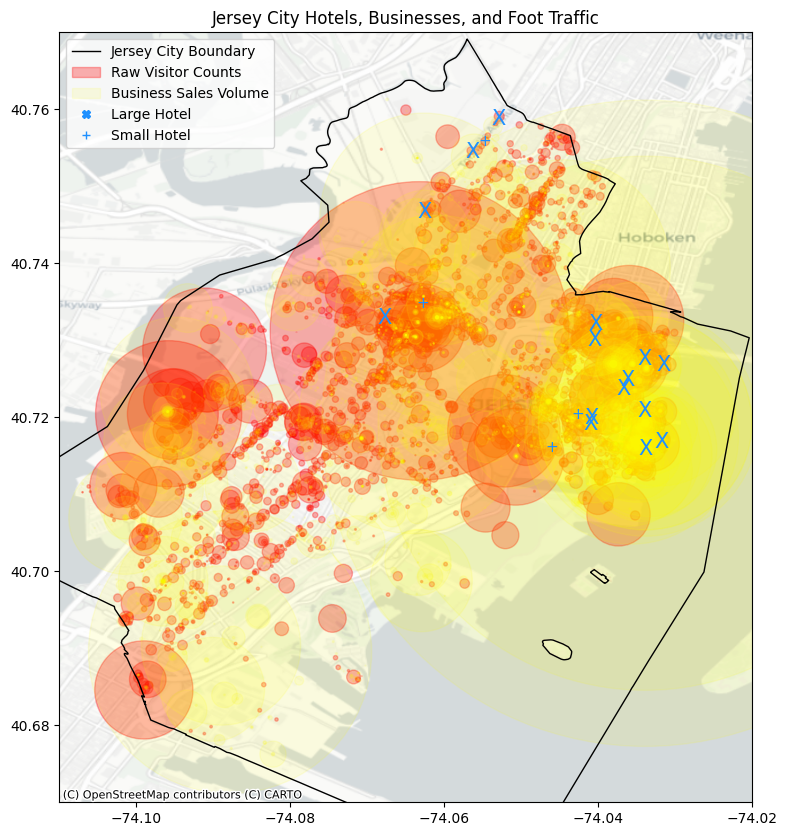

In [193]:
jersey_city_boundary = gpd.GeoDataFrame(geometry=[Jersey_City_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    jersey_city_api_concat_df,
    geometry=gpd.points_from_xy(jersey_city_api_concat_df.longitude, jersey_city_api_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(jersey_city_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = jersey_city_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Jersey City Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Jersey City Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_xlim([-74.11, -74.02])
ax.set_ylim([40.67, 40.77])

ax.set_title("Jersey City Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker], loc="upper left")

plt.show()


### Jersey City WebCrawl

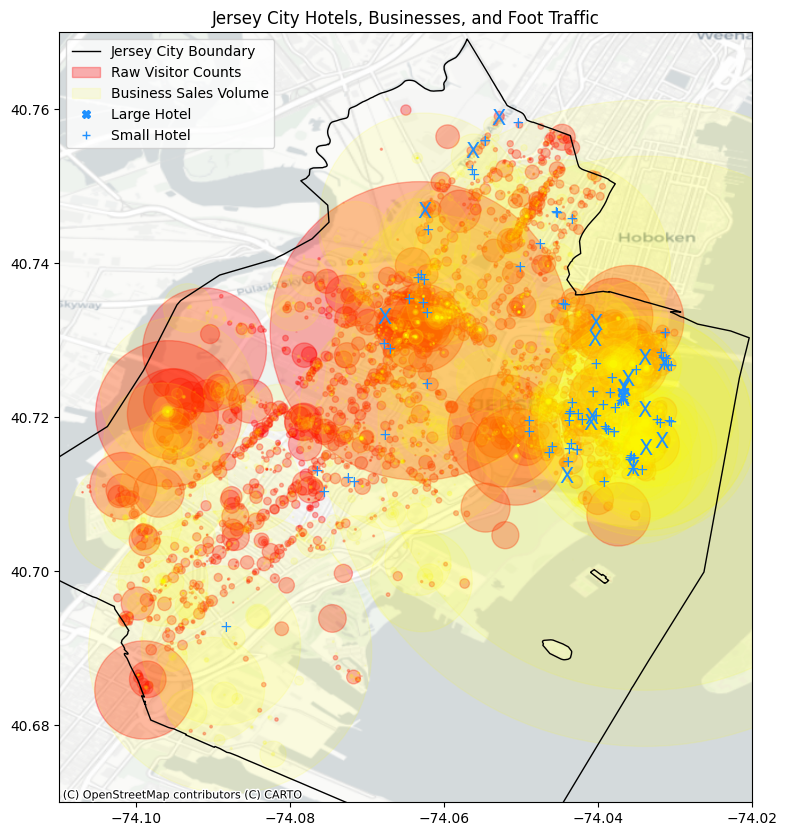

In [192]:
jersey_city_boundary = gpd.GeoDataFrame(geometry=[Jersey_City_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    jersey_city_crawled_concat_df,
    geometry=gpd.points_from_xy(jersey_city_crawled_concat_df.longitude, jersey_city_crawled_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(jersey_city_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = jersey_city_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Jersey City Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Jersey City Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_xlim([-74.11, -74.02])
ax.set_ylim([40.67, 40.77])

ax.set_title("Jersey City Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker], loc="upper left")

plt.show()


# Sunnyvale

In [194]:
sunnyvale_info_df = create_infogroup_df(INFO_PATH, "SUNNYVALE", "CA")   

In [195]:
sunnyvale_patterns_df = pd.read_parquet(f"{DATA_PATH}/foot-traffic/sunnyvale_full_patterns.parquet")

In [196]:
sunnyvale_patterns_df.loc[:, "city"] = sunnyvale_patterns_df.loc[:, "city"].str.lower().str.strip()
sunnyvale_patterns_df.loc[:, "year"] = sunnyvale_patterns_df.loc[:, "date_range_start"].str[0:4].astype("Int64")
sunnyvale_foot_df = sunnyvale_patterns_df.loc[(sunnyvale_patterns_df.loc[:, "year"] >= 2018), :]
sunnyvale_foot_df.loc[:, "location_name"] = sunnyvale_foot_df.loc[:, "location_name"].str.upper().str.strip()
sunnyvale_foot_df.loc[:, "street_address"] = sunnyvale_foot_df.loc[:, "street_address"].str.upper().str.strip()
sunnyvale_foot_traffic_df = sunnyvale_foot_df.groupby(["location_name", "latitude", "longitude", "street_address"]).agg({"raw_visit_counts": "sum", "raw_visitor_counts": "sum"}).reset_index()
sunnyvale_foot_traffic_df.columns

Index(['location_name', 'latitude', 'longitude', 'street_address',
       'raw_visit_counts', 'raw_visitor_counts'],
      dtype='object')

In [197]:
sunnyvale_foot_traffic_df.head(5)

location_name   latitude   longitude             street_address  \
0  10 BUTCHERS KOREAN BBQ  37.362863 -122.025467       595 E EL CAMINO REAL   
1         24 HOUR FITNESS  37.351274 -122.030930          150 E FREMONT AVE   
2         24 HOUR FITNESS  37.364185 -122.031486  762 SUNNYVALE SARATOGA RD   
3         24 HOUR FITNESS  37.381072 -121.995114          1211 E ARQUES AVE   
4   3D MICROBLADING BY JT  37.394201 -121.996788          255 VELVETLAKE DR   

   raw_visit_counts  raw_visitor_counts  
0            4745.0              3504.0  
1           20014.0              6209.0  
2           46231.0             14117.0  
3           19972.0              6329.0  
4            2000.0               989.0

In [198]:
sunnyvale_api_hotel_df = pd.read_csv(f"{DATA_PATH}/tripadvisor_data/Sunnyvale_hotels_api.csv")
sunnyvale_crawled_hotel_df = pd.read_csv(f"{DATA_PATH}/tripadvisor_data/Sunnyvale_hotels_crawled.csv")

In [199]:
sunnyvale_business_df = change_infogroup_column_names(sunnyvale_info_df)
sunnyvale_foot_traffic_df = change_foottraffic_column_names(sunnyvale_foot_traffic_df)

sunnyvale_api_concat_df = pd.concat([sunnyvale_api_hotel_df, sunnyvale_foot_traffic_df, sunnyvale_business_df], ignore_index=True)
sunnyvale_crawled_concat_df = pd.concat([sunnyvale_crawled_hotel_df, sunnyvale_foot_traffic_df, sunnyvale_business_df], ignore_index=True)

In [200]:
Sunnyvale_geo = thw.CityGeo("Sunnyvale")

### Sunnyvale API

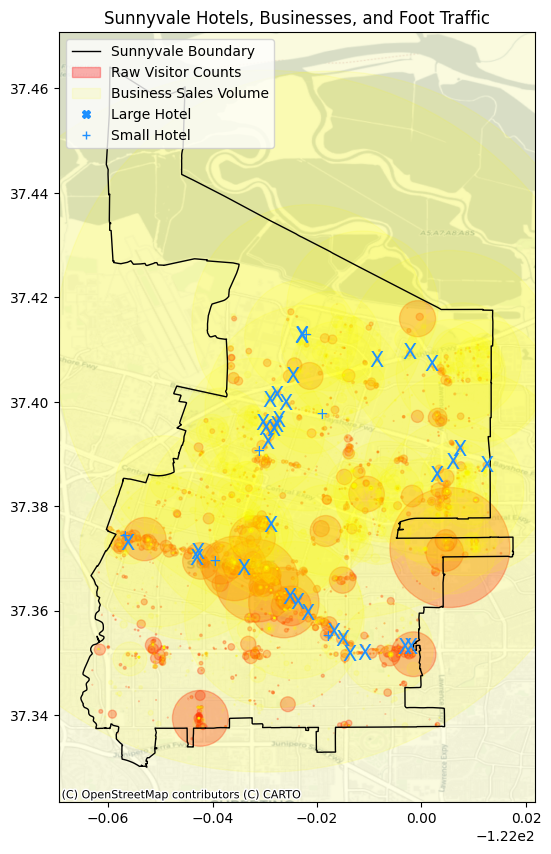

In [201]:
sunnyvale_boundary = gpd.GeoDataFrame(geometry=[Sunnyvale_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    sunnyvale_api_concat_df,
    geometry=gpd.points_from_xy(sunnyvale_api_concat_df.longitude, sunnyvale_api_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(sunnyvale_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = sunnyvale_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Sunnyvale Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Sunnyvale Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# ax.set_xlim([-95.1, -94.7])
# ax.set_ylim([29.10, 29.40])

ax.set_title("Sunnyvale Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker], loc="upper left")


plt.show()


### Sunnyvale WebCrawl

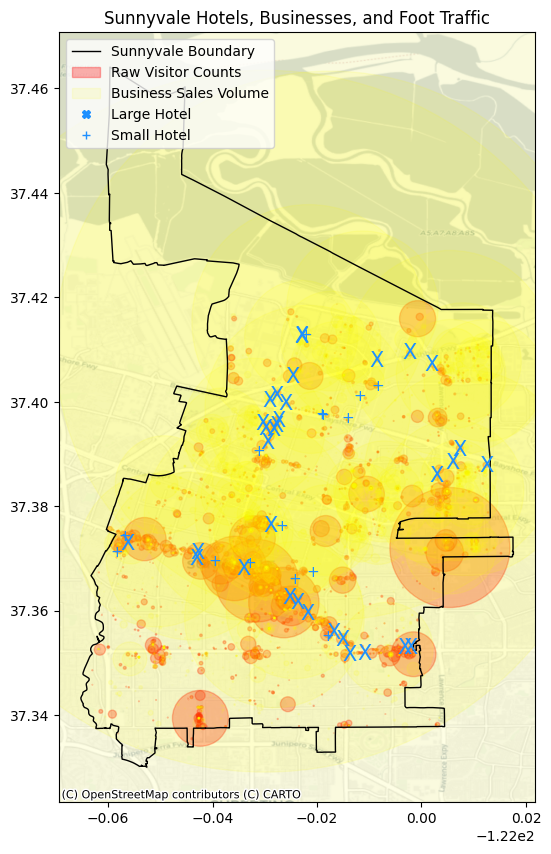

In [202]:
sunnyvale_boundary = gpd.GeoDataFrame(geometry=[Sunnyvale_geo.geo], crs="EPSG:4326")

plot_gdf = gpd.GeoDataFrame(
    sunnyvale_crawled_concat_df,
    geometry=gpd.points_from_xy(sunnyvale_crawled_concat_df.longitude, sunnyvale_crawled_concat_df.latitude),
    crs="EPSG:4326"
)
plot_gdf = plot_gdf[plot_gdf.geometry.within(sunnyvale_boundary.unary_union)]

fig, ax = plt.subplots(figsize=(10, 10))
boundary_plot = sunnyvale_boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Sunnyvale Boundary")

boundary_line = Line2D([0], [0], color="black", linewidth=1, label="Sunnyvale Boundary")
visitor_patch = mpatches.Circle((0, 0), 0.1, color="red", alpha=0.3, label="Raw Visitor Counts")
sales_patch = mpatches.Circle((0, 0), 0.1, color="yellow", alpha=0.1, label="Business Sales Volume")
large_hotel_marker = Line2D([0], [0], marker="X", color="dodgerblue", label="Large Hotel", linestyle="None")
small_hotel_marker = Line2D([0], [0], marker="+", color="dodgerblue", label="Small Hotel", linestyle="None")

visitor_scale_factor = 0.0000001
sales_scale_factor = 0.0000001

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["raw_visitor_counts"] * visitor_scale_factor,
        color="red", alpha=0.3
    ))

for idx, row in plot_gdf.iterrows():
    ax.add_patch(plt.Circle(
        (row.geometry.x, row.geometry.y),
        row["sales_volume"] * sales_scale_factor,
        color="yellow", alpha=0.1
    ))

for idx, row in plot_gdf.dropna(subset=["location_id"]).iterrows():
    if row.get("number_of_rooms") >= 40:
        ax.text(row.geometry.x, row.geometry.y, "X", color="dodgerblue", fontsize=15, ha="center", va="center")
    else:
        ax.text(row.geometry.x, row.geometry.y, "+", color="dodgerblue", fontsize=11, ha="center", va="center")

ctx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# ax.set_xlim([-95.1, -94.7])
# ax.set_ylim([29.10, 29.40])

ax.set_title("Sunnyvale Hotels, Businesses, and Foot Traffic")

ax.legend(handles=[boundary_line, visitor_patch, sales_patch, large_hotel_marker, small_hotel_marker], loc="upper left")


plt.show()
